In [ ]:
import os
import torch
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from sklearn import svm
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import Dataset,DataLoader
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,ConfusionMatrixDisplay,classification_report

In [ ]:
def pad_image(image_path):
  """
  Resize image to 224 height and adjust width to protect aspect ratio.
  Pad image to make 350,350 square image.
  """
  image = Image.open(image_path).convert('RGB')
  new_img = Image.new('RGB',(350,350),color=0)
  image = T.Resize(224,max_size=320)(image)
  x = (new_img.width - image.width) // 2
  y = (new_img.height - image.height) // 2
  new_img.paste(image,(x,y))
  return new_img, new_img.size

## To manipulate data.
def sort_list(lst,isImage:bool=True):
  """
  Sort given list
  isImage used to check for images list or json list is given.
  """
  if not isImage:
    s = 5
  else:
    s = 4
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-s:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def display_images_labels(imgs_lst,image_label_dictionary):
  """
  Return dataframe contains images and corresponding labels.
  """
  return pd.DataFrame({
      "Image" : [img for img in imgs_lst],
      "Label" : [image_label_dictionary[img] for img in imgs_lst]
  })

def create_list(dir,isImage=True,sort=False,fullPath=False):
  """
  Create list given directory.
  """
  lst = os.listdir(dir)

  if sort:
    lst = sort_list(lst,isImage)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def merge_directories(dir1,dir2,isImage=True,sort=False,fullPath=False):
  """
  Merge two directory.
  """
  list1 = create_list(dir1,isImage,sort,fullPath)
  list2 = create_list(dir2,isImage,sort,fullPath)
  total = list1 + list2
  return total

def get_selected_indexes(indexs:list,elements_list:list):
  """
  Get elements from elemnts list given their indexs.
  """
  arr = []
  for idx in indexs:
    arr.append(elements_list[idx])
  return arr

def get_values(keys,dictionary):
  """
  Given  keys, returns values from dictionary.
  """
  arr = []
  for key in keys:
    arr.append(dictionary[key])
  return arr

def create_dict(keys,values):
  """
  Return created dictionary.
  """
  dictionary = {}
  for i,k in enumerate(keys):
    dictionary[k] = values[i]
  return dictionary

def create_img_label_dict(imgs_lst,labels_lst,column_num:int):
  """
  create dictionary with images as keys and excel labels as values.
  Image list must be sorted before call this function.
  For sorting call sort_image_list function before.
  """
  _dict = {}
  for i,img in enumerate(imgs_lst):
    _dict[img] = labels_lst.iloc[i,column_num]
  return _dict

## For controls.
def search(arr,start_index,element):
  """
  Search for elemnt in given Arrays.
  If found returns searched element, else returns -1.
  """
  if element ==-1:
    j=start_index+1
    element = arr[start_index]
  else:
    j=0
  while j<len(arr):
    if element == arr[j]:
      return element
    else:
      j+=1
  return -1

def getNotFoundElements(arr1,arr2):
  """
  Given aar1, returns elements that not found in arr2.
  """
  not_found= []
  for elm in arr1:
    xx = search(arr2,-1,elm)
    if xx ==-1:
      not_found.append(elm)
  return not_found

def create_cm(actual_labels,predicted,classes,title="Confusion Matrix"):
  """
  Create Confusion Matrix.
  """
  cm = confusion_matrix(actual_labels, predicted)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  cm_display.plot()
  plt.title(title)
  plt.show()

def calculate_metrics(labels,predictions):
  precision = precision_score(labels,predictions)
  recall = recall_score(labels,predictions)
  accuracy = accuracy_score(labels,predictions)
  return accuracy, precision, recall

In [ ]:
def load_image(image,transform):
  ##new_img, _ = pad_image(image)
  new_img = Image.open(image).convert('RGB')
  new_img = transform(new_img)[:3].unsqueeze(0)
  return new_img

def compute_embeddings(image_paths,device,transform,transformer):
  all_embeddings = {}
  with torch.no_grad():
    for _, img in enumerate(tqdm(image_paths,desc="Processing files")):
      embeddings = transformer(load_image(img,transform).to(device))
      all_embeddings[img] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

  #with open("all_embeddings.json", "w") as f:
  #    f.write(json.dumps(all_embeddings))

  return all_embeddings

def test_model(images,img_lbl_dict,embeddings,classes,model):
  embeddings = get_values(images,embeddings)
  embeddings_list = np.array(list(embeddings)).reshape(-1,384)
  with torch.no_grad():
    predictions = model.predict(embeddings_list)
    labels = get_values(images,img_lbl_dict)
    res = calculate_metrics(labels,predictions)
    print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
    create_cm(labels,predictions,classes)

In [ ]:
furkan_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images"
gamze_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/images"
furkan_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/Furkan_Excel.xlsx"
gamze_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/Furkan_Excel.xlsx"
total_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = T.Compose([T.Resize((350,350)),T.ToTensor(),T.Normalize([0.5], [0.5])])
classes = ("Hatasiz" , "Hatali")

In [ ]:
labels = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
images_paths = merge_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
img_lbl_dict = create_img_label_dict(images_paths,labels,column_num=1)
print("labels file length =", len(labels))
print("images list length =", len(images_paths))
print("dictionary  length =", len(img_lbl_dict))

labels file length = 1497
images list length = 1497
dictionary  length = 1497


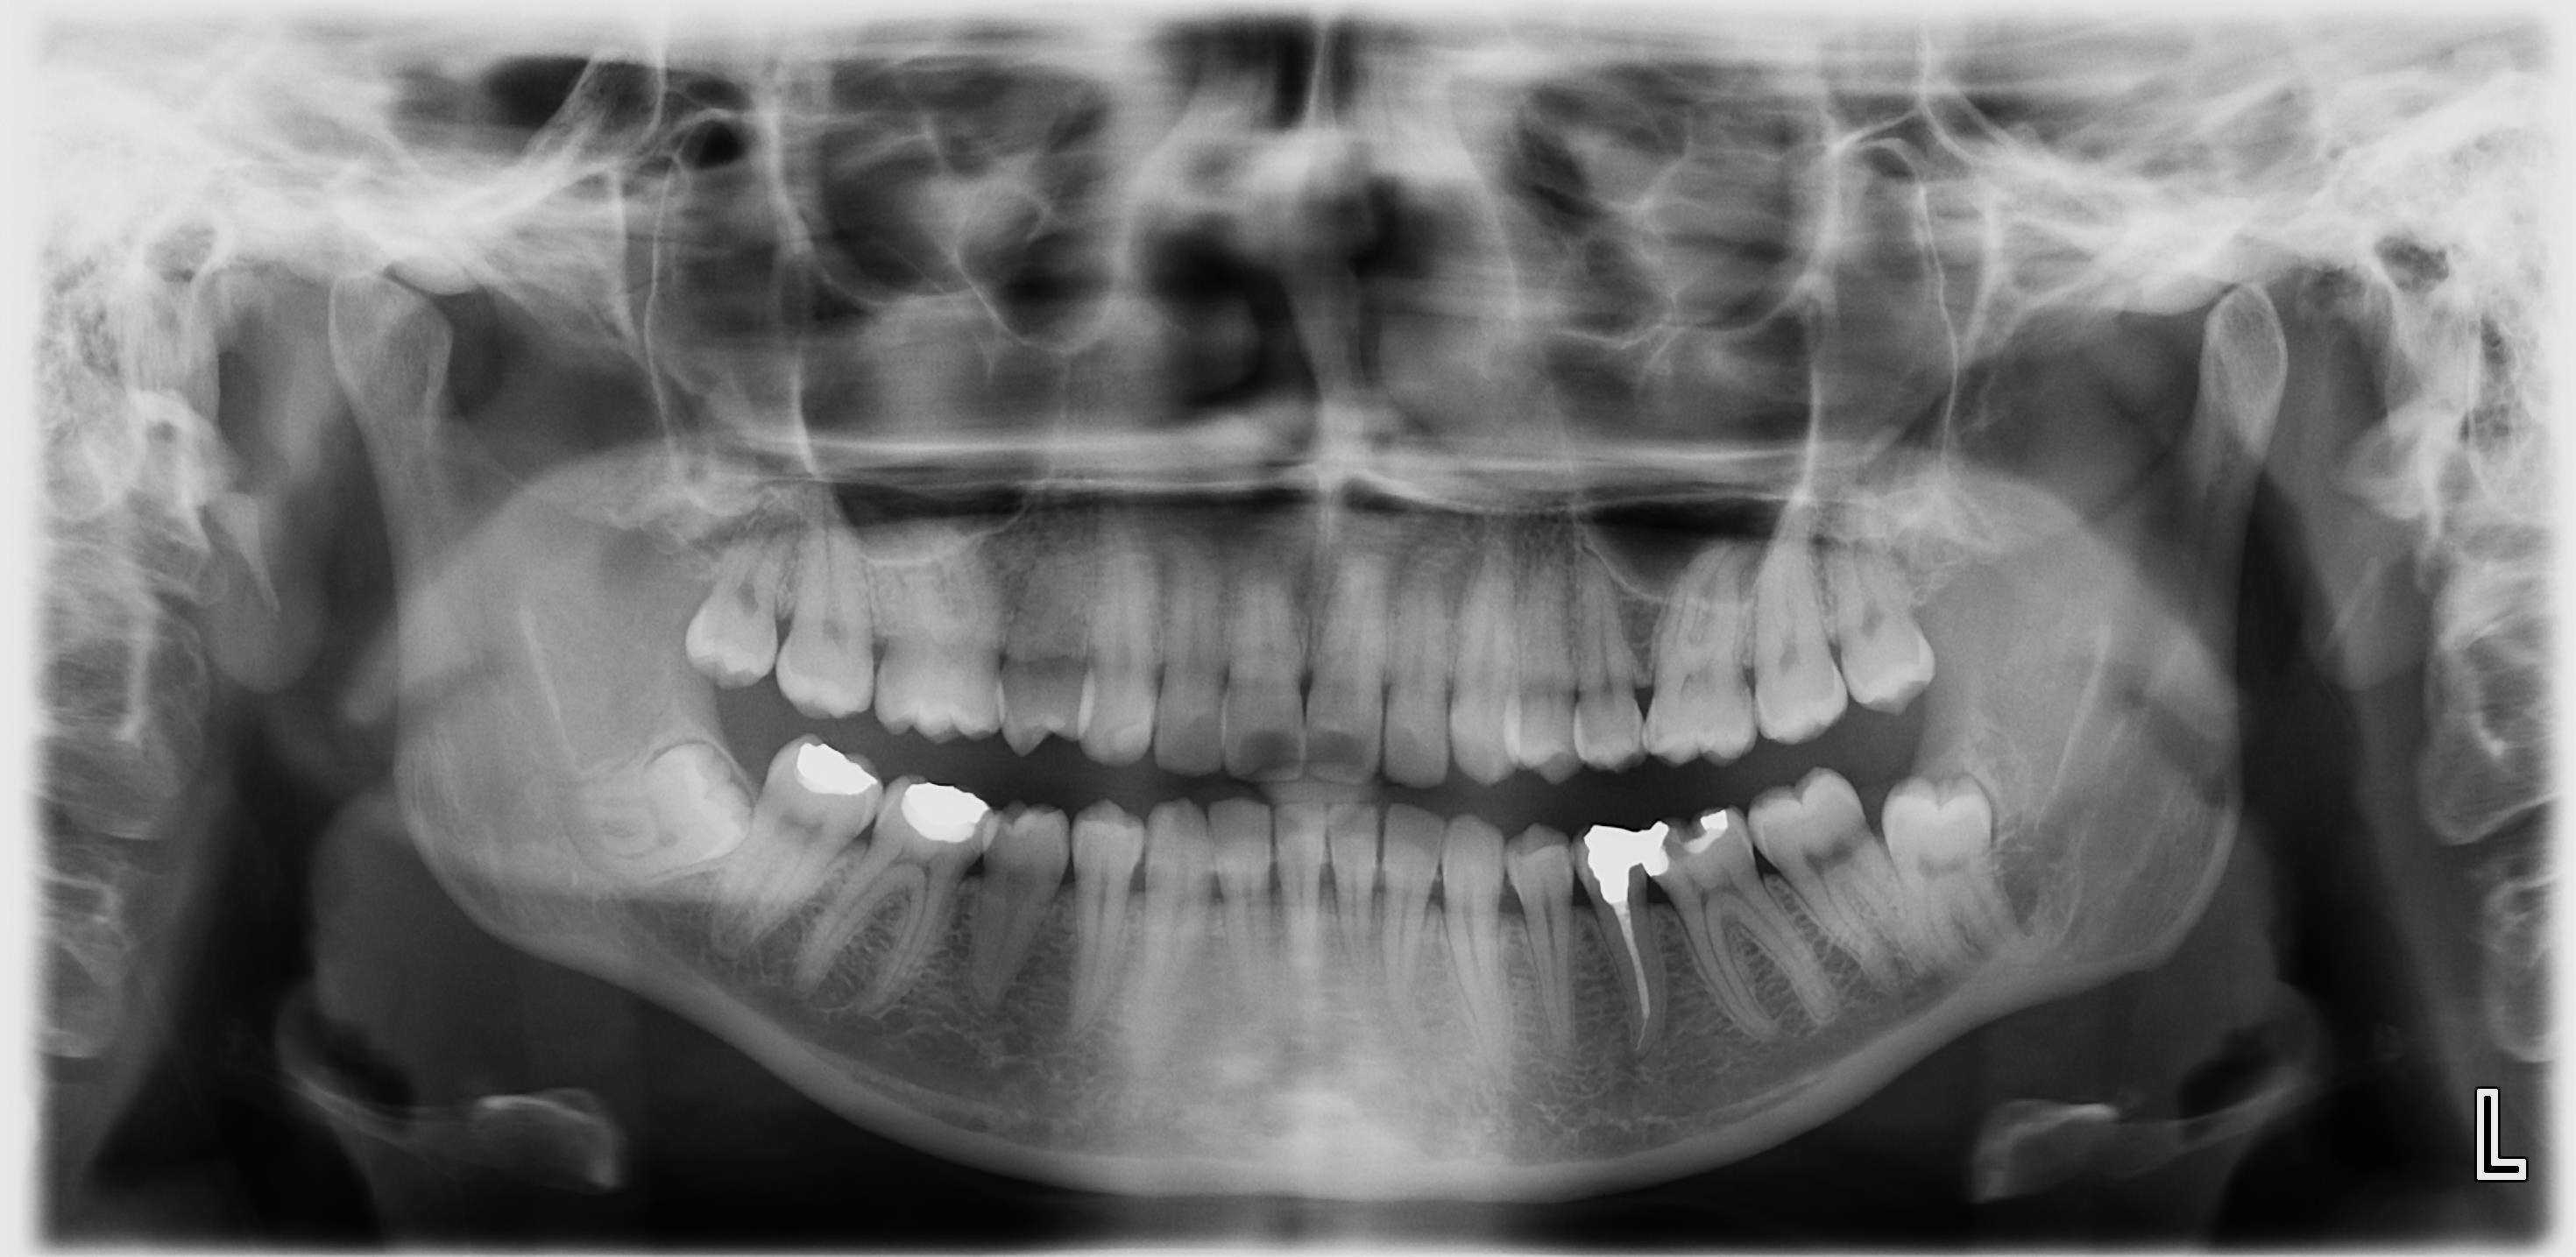

In [ ]:
sample = random.choice(images_paths)
img = Image.open(sample)
img

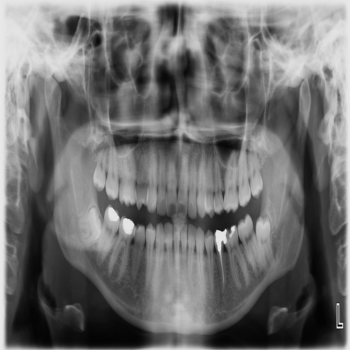

In [ ]:
img = T.Resize((350,350))(img)
img

In [ ]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

In [ ]:
clf = svm.SVC(probability=True,gamma='scale')               ## Initialize classifier
K = 5                                                       ## Number of folds
kf = KFold(n_splits=K)                                      ## Define K-Fold method for cross validation

In [ ]:
total_embeddings = compute_embeddings(images_paths,device,transform,dinov2_vits14)

Processing files: 100%|██████████| 1497/1497 [11:29<00:00,  2.17it/s]


## SVM Classifier

In [ ]:
## Train loop
metrics = []
predicted_lbls = []
actual_lbls = []
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  train_emb = get_values(x_train,total_embeddings)
  test_emb = get_values(x_test,total_embeddings)

  train_emb_list = np.array(list(train_emb)).reshape(-1,384)
  test_emb_list = np.array(list(test_emb)).reshape(-1,384)
  ## Get corresponding labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  model = clf.fit(train_emb_list,y_train)
  predictions = model.predict(test_emb_list)

  predicted_lbls.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
  metrics.append(res)

Fold 1/5
Accuracy: 0.6133333333333333, Precision: 0.5297029702970297, Recall: 0.8359375
Fold 2/5
Accuracy: 0.61, Precision: 0.5795454545454546, Recall: 0.7034482758620689
Fold 3/5
Accuracy: 0.6755852842809364, Precision: 0.7323943661971831, Recall: 0.7959183673469388
Fold 4/5
Accuracy: 0.5050167224080268, Precision: 0.48659003831417624, Recall: 0.900709219858156
Fold 5/5
Accuracy: 0.6153846153846154, Precision: 0.7515527950310559, Recall: 0.6173469387755102


Average Accuracy : 60.386399108138235
Average Precision 61.595712487697995
Average Recall 77.06720603685349


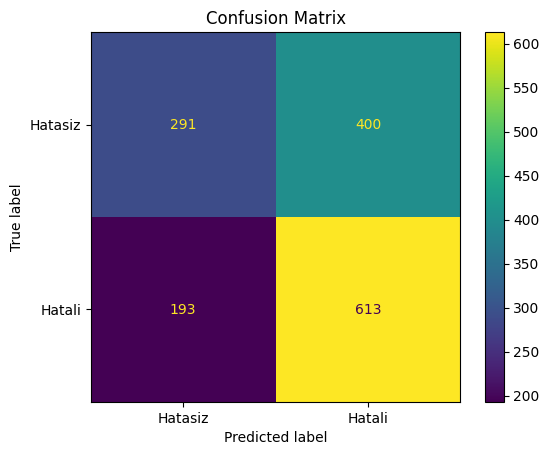

In [ ]:
avg_acc, avg_precision, avg_recall= 0, 0, 0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K

## Print Train metrics results
print("Average Accuracy :", avg_acc)
print("Average Precision", avg_precision)
print("Average Recall", avg_recall)

## Draw confusion matrix
create_cm(actual_lbls,predicted_lbls,classes)

Accuracy: 0.6452905811623246, Precision: 0.6674786845310596, Recall: 0.6799007444168734


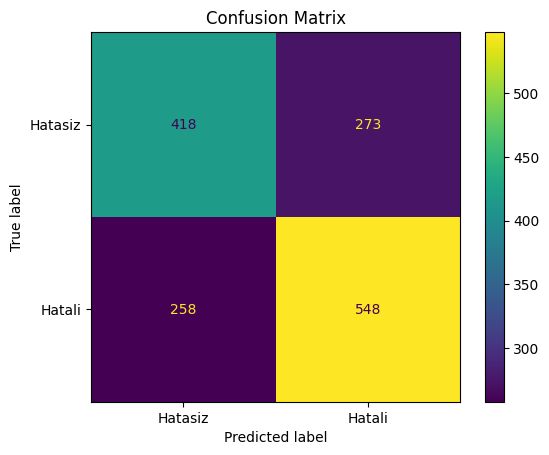

In [ ]:
## Test final model
test_model(images_paths,img_lbl_dict,total_embeddings,classes,model)

In [ ]:
## Save the model
#with open('./dinv2_vit14_model_with_svm.pth', 'wb') as model_file:
#    pickle.dump(model, model_file)

## K-NN Classifier

Fold 1/5
Accuracy: 0.57, Precision: 0.4956521739130435, Recall: 0.4453125
Fold 2/5
Accuracy: 0.5666666666666667, Precision: 0.556390977443609, Recall: 0.5103448275862069
Fold 3/5
Accuracy: 0.5150501672240803, Precision: 0.6946564885496184, Recall: 0.4642857142857143
Fold 4/5
Accuracy: 0.5217391304347826, Precision: 0.49390243902439024, Recall: 0.574468085106383
Fold 5/5
Accuracy: 0.5652173913043478, Precision: 0.72, Recall: 0.5510204081632653
Average Accuracy : 54.77346711259755
Average Precision 59.21204157861322
Average Recall 50.90863070283139


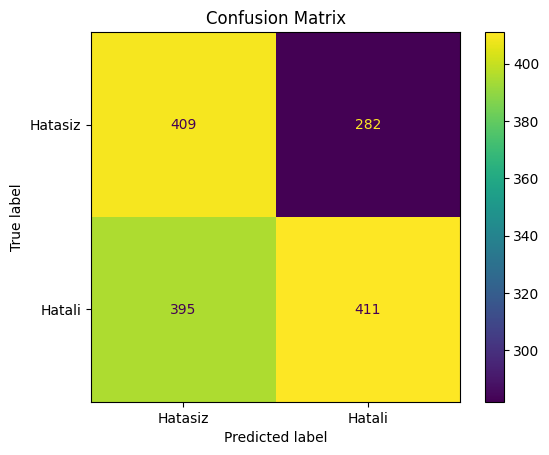

In [ ]:
clf1 = KNeighborsClassifier(n_neighbors=5,metric="euclidean")
## Train loop
metrics = []
predicted = []
actual_lbls = []
model1 = None
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  train_emb = get_values(x_train,total_embeddings)
  test_emb = get_values(x_test,total_embeddings)

  train_emb_list = np.array(list(train_emb)).reshape(-1,384)
  test_emb_list = np.array(list(test_emb)).reshape(-1,384)
  ## Get corresponding labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  model1 = clf1.fit(train_emb_list,y_train)
  predictions = model1.predict(test_emb_list)

  predicted.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
  metrics.append(res)


avg_acc, avg_precision, avg_recall= 0, 0, 0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K
print("Average Accuracy :", avg_acc)
print("Average Precision", avg_precision)
print("Average Recall", avg_recall)

create_cm(actual_lbls,predicted,classes)          ## Draw confusion matrix

Accuracy: 0.6806947227788911, Precision: 0.7462462462462462, Recall: 0.6166253101736973


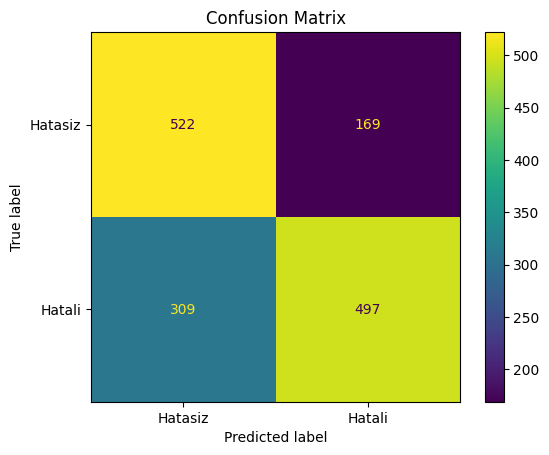

In [ ]:
## Test final model
test_model(images_paths,img_lbl_dict,total_embeddings,classes,model1)

## Naive Bayes Classifier

Fold 1/5
Accuracy: 0.56, Precision: 0.4846153846153846, Recall: 0.4921875
Fold 2/5
Accuracy: 0.6266666666666667, Precision: 0.6222222222222222, Recall: 0.5793103448275863
Fold 3/5
Accuracy: 0.6321070234113713, Precision: 0.7009345794392523, Recall: 0.7653061224489796
Fold 4/5
Accuracy: 0.5083612040133779, Precision: 0.4868421052631579, Recall: 0.7872340425531915
Fold 5/5
Accuracy: 0.5284280936454849, Precision: 0.706766917293233, Recall: 0.47959183673469385
Average Accuracy : 57.11125975473802
Average Precision 60.02762417666501
Average Recall 62.07259693128903


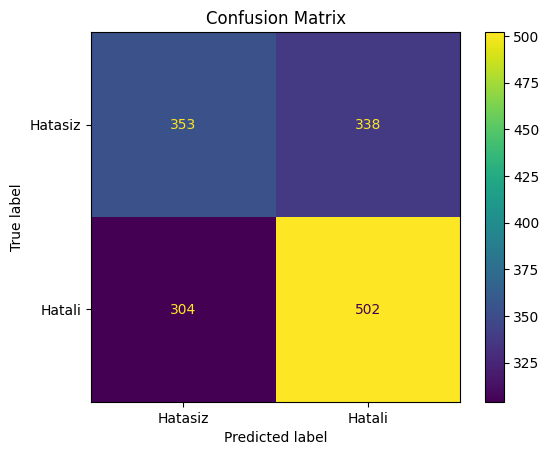

In [ ]:
NB = BernoulliNB()
## Train loop
metrics = []
predicted = []
actual_lbls = []
model2 = None
for i, (train_index, test_index) in enumerate(kf.split(images_paths)):
  print(f"Fold {i+1}/{K}")
  ## Get select images for train/test folds.
  x_train = get_selected_indexes(train_index,images_paths)
  x_test  = get_selected_indexes(test_index,images_paths)

  train_emb = get_values(x_train,total_embeddings)
  test_emb = get_values(x_test,total_embeddings)

  train_emb_list = np.array(list(train_emb)).reshape(-1,384)
  test_emb_list = np.array(list(test_emb)).reshape(-1,384)
  ## Get corresponding labels.
  y_train = get_values(x_train,img_lbl_dict)
  y_test = get_values(x_test,img_lbl_dict)

  model2 = NB.fit(train_emb_list,y_train)
  predictions = NB.predict(test_emb_list)

  predicted.extend(predictions)
  actual_lbls.extend(y_test)
  res = calculate_metrics(y_test,predictions)
  print(f"Accuracy: {res[0]}, Precision: {res[1]}, Recall: {res[2]}")
  metrics.append(res)


avg_acc, avg_precision, avg_recall= 0, 0, 0
acc = []
for i in range(K):
    avg_acc += metrics[i][0]
    acc.append(metrics[i][0])
    avg_precision += metrics[i][1]
    avg_recall += metrics[i][2]

avg_acc = 100*avg_acc/K
avg_precision = 100*avg_precision/K
avg_recall = 100*avg_recall/K
print("Average Accuracy :", avg_acc)
print("Average Precision", avg_precision)
print("Average Recall", avg_recall)

create_cm(actual_lbls,predicted,classes)          ## Draw confusion matrix

Accuracy: 0.6032064128256514, Precision: 0.6391076115485564, Recall: 0.6042183622828784


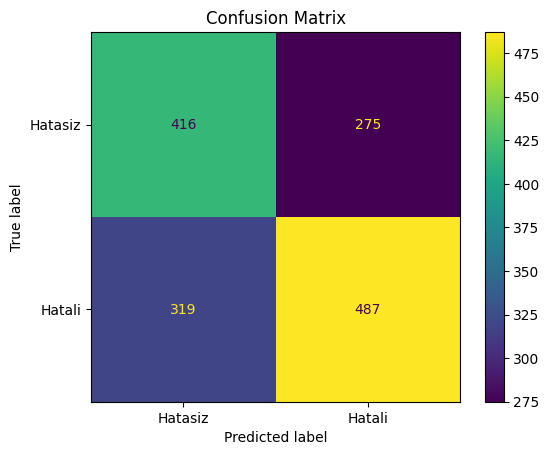

In [ ]:
## test final model
test_model(images_paths,img_lbl_dict,total_embeddings,classes,model2)